# LIT-PCBA 
this dataset is a proposed "more difficult" test than DUD-E. I used a 75/25 (sklearn default) stratified split. The dataset is heavily imbalanced, like DUD-E.

- UPDATE: I'm using the AVE split now

In [1]:
import pickle
from sklearn.metrics import roc_auc_score
import numpy as np
import seaborn as sns
import torch
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from pathlib import Path
from sklearn.metrics import f1_score, recall_score
import matplotlib.pyplot as plt
import sys
# sys.path.append('..')
sys.path.insert(0, "/g/g13/jones289/workspace/hd-cuda-master")
# print(sys.path)
import hdpy
import hdpy.ecfp
# from hdpy.analysis import load_pkl
from hdpy.metrics import compute_enrichment_factor
from pathlib import Path


plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=17)
plt.rc('figure', titlesize=20)


# SEED=125
SEED=5
# SEED=2

data_p = Path(f"/p/vast1/jones289/hd_results/{SEED}")

In [2]:
green_color_pal = sns.color_palette("Greens", 10)
blue_color_pal = sns.color_palette("Blues", 10)
rocket_color_pal = sns.color_palette("rocket", 10)

In [3]:
model_dict = {
    "molehd-bpe": ("MoleHD-BPE", rocket_color_pal[4]),
#     "hdbind-rp-molformer": ("HDBind+MolFormer", green_color_pal[4]),
    "hdbind-rp-ecfp-1024-1-100": ("HDBind+ECFP-100", green_color_pal[6]),
    "hdbind-rp-ecfp-1024-1-1k": ("HDBind+ECFP-1k", green_color_pal[6]),
    "hdbind-rp-ecfp-1024-1": ("HDBind+ECFP-10k", green_color_pal[6]),
    "hdbind-rp-ecfp-1024-1-100k": ("HDBind+ECFP-100k", green_color_pal[6]),
    "hdbind-rp-ecfp-1024-1-1m": ("HDBind+ECFP-1m", green_color_pal[6]),    
    "mlp-1024-1": ("MLP", blue_color_pal[7]),
    "Vina": ("Vina", "salmon"),
}

# LIT-PCBA Results

export CONDA_ROOT=/usr/workspace/jones289/anaconda3-power #installed using the LC installer script
export PATH=$CONDA_ROOT/bin:$PATH
export CONDA_EXE=$CONDA_ROOT/bin/conda
ml load gcc/11
export PYTHONPATH=$PWD:$PYTHONPATH
source activate /usr/workspace/jones289/anaconda3-power/envs/opence-1.8.0

In [4]:
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score


def compute_metrics(y_pred, y_score, y_true, p):
#     import pdb
#     pdb.set_trace()


    if y_score.squeeze().ndim == 2:
        enrich = float(compute_enrichment_factor(scores=y_score[:, 1], labels=y_true, n_percent=p))
        roc = roc_auc_score(y_score=y_score[:, 1], y_true=y_true)
    else:
        enrich = float(compute_enrichment_factor(scores=y_score, labels=y_true, n_percent=p))
        roc = roc_auc_score(y_score=y_score, y_true=y_true)

    
    
    return {"precision": precision_score(y_pred=y_pred, y_true=y_true, zero_division=0),
            "recall": recall_score(y_pred=y_pred, y_true=y_true),
           "f1": f1_score(y_pred=y_pred, y_true=y_true, zero_division=0),
            "enrich": enrich,            
           "roc": roc
           }


def aggregate_results(dataset, split):
    
    
    
    if split == "random":
        raise NotImplementedError # rename the files with "-random" to be consistent
        
    
    model_metric_dict = {"model": [], "enrich": [], "p":[], "train_time":[], "test_time": [], "target": [],
                        "seed": [], "recall": [], "precision": [], "f1": [], 
                        }

    
    
    df_list = []
    for model_name, model_tup in tqdm(model_dict.items(), total=len(model_dict), position=0):
                        

        data_path_list = list(data_p.glob(f"{model_name}.{dataset}-*-{split}*.pkl"))
        print(f"{model_name}\t{dataset}\t{len(model_tup)}\t {len(data_path_list)}")

        

        for path in tqdm(data_path_list, total=len(data_path_list), position=1):
            target = path.name.split(".")[1]

            print(target, path, model_name)

            
#             model_data_dict = pd.read_pickle(path)

            try:
                model_data_dict = torch.load(path)
#                 model_data_dict = np.load(path)
            except RuntimeError as e:
                print(e)
                print("fixing pickle and saving as pytorch object")
                with open(path, "rb") as handle:
                    model_data_dict = pickle.load(handle)
                    torch.save(model_data_dict, path)
            

            
            
            for seed in range(len(model_data_dict['trials'])):
                scores_smiles_dict = {"smiles": None,
                                      "model": None,
                                      "target": None, 
                                      "score": None,
                                      "seed": None, 
                                      "label": None}
    
                
                trial_dict = model_data_dict['trials'][seed]

                y_test = model_data_dict["y_test"]

#                 import pdb
#                 pdb.set_trace()
                if "mlp" in model_name:
                    scores_smiles_dict["score"] = model_data_dict['trials'][seed]["eta"].reshape(-1,2)[:,1].flatten()
                    
                else:
                    scores_smiles_dict["score"] = model_data_dict['trials'][seed]["eta"].flatten()



                scores_smiles_dict["smiles"] = model_data_dict["smiles_test"]
                scores_smiles_dict["target"] = np.array([target]*len(y_test)).flatten()
                scores_smiles_dict["label"] = model_data_dict['trials'][seed]["y_true"].flatten()
                scores_smiles_dict["model"] = np.array([model_name]*len(y_test)).flatten()
                scores_smiles_dict["seed"] = np.array([seed]*len(y_test)).flatten()
                
#                 for key, value in scores_smiles_dict.items():
#                     print(key, value.shape)
            
                df_list.append(pd.DataFrame(scores_smiles_dict))
#                 import pdb
#                 pdb.set_trace()
                actives_database = sum(y_test)
                database_size = y_test.shape[0]



                hdc_conf_scores = trial_dict["eta"]
                for p in [.01, .1]:

                    try:

                        metrics = compute_metrics(y_pred=trial_dict["y_pred"], 
                                                  y_score=hdc_conf_scores, 
                                                  y_true=model_data_dict["y_test"],
                                                 p=p)

                        model_metric_dict["target"].append(target)
                        model_metric_dict["test_time"].append(trial_dict["test_time"])
                        model_metric_dict["enrich"].append(metrics["enrich"])
                        model_metric_dict["p"].append(p)
                        model_metric_dict["seed"].append(seed)
                        model_metric_dict["precision"].append(metrics["precision"])
                        model_metric_dict["recall"].append(metrics["recall"])
                        model_metric_dict["f1"].append(metrics["f1"])
                        model_metric_dict["model"].append(model_name)
                    except Exception as e:
                        print(e)


    model_metric_df = pd.DataFrame({key: value for key, value in model_metric_dict.items() if key not in ["train_time", "test_time", "precision", "recall", "f1"]})
#     return model_metric_df, pd.DataFrame(scores_smiles_dict)
#     return model_metric_df, None
    return model_metric_df, df_list
        


In [5]:
# litpcba_df, smiles_scores_df = aggregate_results(dataset="lit-pcba", split="ave")

In [6]:
# lit_pcba_scores_df = pd.concat(smiles_scores_df)

In [7]:
# lit_pcba_scores_df.groupby(["model", "target", "smiles"])["score"].mean()

# VINA result

In [8]:
from pathlib import Path

def load_lit_pcba_vina(nrows=None):
    root_p = Path("/p/lustre2/ahashare/zhang30/LIT-PCBA-Data/")
    lig_map_p = Path("/p/lustre2/ahashare/zhang30/LIT-PCBA-Data/lig_rec/")
#     /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/lig_rec/ # this path stores the map between conveyor and the original files
    
    
    
    
    path_list = [path for path in root_p.glob("*-actives.csv")]
#     import pdb
#     pdb.set_trace()
#     path_list = [path_list[0]]

    df_list = []

    for idx, path in tqdm(enumerate(path_list), total=len(path_list)):
        print(idx, path)
        
        target = path.name.split(".")[0].split("-")[0]
#         print(target, idx+1, path)

        
        active_lig_map = pd.read_csv(lig_map_p / f"lig-{target}-actives.csv")
        inactive_lig_map = pd.read_csv(lig_map_p / f"lig-{target}-inactives.csv")
        
        lig_map = pd.concat([active_lig_map, inactive_lig_map])
        
        active_smiles_df = pd.read_csv(f"/p/vast1/jones289/lit_pcba/{target}/actives.smi", delim_whitespace=True, header=None)
        inactive_smiles_df = pd.read_csv(f"/p/vast1/jones289/lit_pcba/{target}/inactives.smi", delim_whitespace=True, header=None)
        smiles_df = pd.concat([active_smiles_df, inactive_smiles_df])

        
        target_df = pd.merge(lig_map, smiles_df, left_on=" name", right_on=1)
        
        dock_score_cols = {idx: value for idx,value in enumerate(["file", "key", "Mesg", "Box/cx", "Box/cy", "Box/cz", "Box/dx", "Box/dy", "Box/dz", 
                       "ligName", 
                       "numPose", 
                       "scores/1", 
                       "scores/2", 
                       "scores/3", 
                       "scores/4", 
                       "scores/5", 
                       "scores/6", 
                       "scores/7", 
                       "scores/8", 
                       "scores/9", 
                       "scores/10", 
                       "Box/default"])}
        lig_id_col = 9
        active_dock_scores = pd.read_csv(root_p / Path(f"{target}-actives.csv.clean"), header=None)
        active_dock_scores["label"] = [1] * len(active_dock_scores)
        
        inactive_dock_scores = pd.read_csv(root_p / Path(f"{target}-inactives.csv.clean"), header=None)
        inactive_dock_scores["label"] = [0] * len(inactive_dock_scores)
#         import pdb
#         pdb.set_trace()
        dock_scores = pd.concat([active_dock_scores, inactive_dock_scores])
#         dock_scores = dock_scores.rename(dock_score_cols)
        
        
        dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
        
        
        dock_scores = dock_scores.groupby(lig_id_col)[[lig_id_col, 'min_vina', 'label']].min().reset_index(drop=True)
        
        
        target_df = pd.merge(dock_scores, target_df, left_on=9, right_on=" name")
        
        target_df["target"] = [target] * len(target_df)
        
        
#         import pdb
#         pdb.set_trace()
        
        
        # compute enrichment at 1% and 10%
        
        
        df_list.append(target_df)
        
        
        
#         import pdb
#         pdb.set_trace()
        
    '''

        merged_df = None
        merged_df_path = Path(f"./lit_pcba_docking_analysis/{target}.csv") # todo: delete this directory
        
#         if not merged_df_path.exists():
        if True:
            # can use the set of smiles in each result file
            
            # todo (10/18/23): is this valid?
            # (12/12/23): ????
#             result_pkl = Path(f"/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/124/lit_pcba.{target}.ecfp.atomwise.0.pkl")        


#             target_train_smiles_list = []
#             target_test_smiles_list = []

#             with open(result_pkl, "rb") as handle:

#                 data = pickle.load(handle)

#                 target_train_smiles_list = data["smiles_train"]
#                 target_test_smiles_list = data["smiles_test"]

#                 print(f"total of {len(target_train_smiles_list)} in training set, total of {len(target_test_smiles_list)} in testing set.")

#             df_cols = ['file', ' scores/1', ' ligName']
    
            df_cols = {idx: value for idx,value in enumerate(["file", "key", "Mesg", "Box/cx", "Box/cy", "Box/cz", "Box/dx", "Box/dy", "Box/dz", 
                       "ligName", 
                       "numPose", 
                       "scores/1", 
                       "scores/2", 
                       "scores/3", 
                       "scores/4", 
                       "scores/5", 
                       "scores/6", 
                       "scores/7", 
                       "scores/8", 
                       "scores/9", 
                       "scores/10", 
                       "Box/default"])}
            
            
            
#             active_df = pd.read_csv(root_p / Path(f"{target}-actives.csv.clean"), sep=",", usecols=df_cols, nrows=nrows)
            active_df = pd.read_csv(root_p / Path(f"{target}-actives.csv.clean"), sep=",", nrows=nrows, header=None)
    
            active_df['y_true'] = [1] * len(active_df)

#             inactive_df = pd.read_csv(root_p / Path(f"{target}-inactives.csv.clean"), sep=",", usecols=df_cols, nrows=nrows)
            inactive_df = pd.read_csv(root_p / Path(f"{target}-inactives.csv.clean"), sep=",", nrows=nrows, header=None)
            inactive_df['y_true'] = [0] * len(inactive_df)

            target_df = pd.concat([active_df, inactive_df])
            target_df = target_df.rename(df_cols)
            import pdb
            pdb.set_trace()
            # this will search over all of the docking results for each target, across each of the multiple protein models

            active_smiles_df = pd.read_csv(f"/p/vast1/jones289/lit_pcba/{target}/actives.smi", delim_whitespace=True, header=None)
            inactive_smiles_df = pd.read_csv(f"/p/vast1/jones289/lit_pcba/{target}/inactives.smi", delim_whitespace=True, header=None)
            target_smiles_df = pd.concat([active_smiles_df, inactive_smiles_df])



            top_pose_target_df = target_df.groupby([' ligName'], as_index=False)[[' ligName', ' scores/1', 'y_true']].min()


        
            merged_df_path.parent.mkdir(exist_ok=True, parents=True)
            merged_df = pd.merge(top_pose_target_df, target_smiles_df, left_on=" ligName", right_on=1)
            merged_df = merged_df[merged_df.apply(lambda x: x[0] in target_test_smiles_list, axis=1)]
            merged_df['target'] = [target] * len(merged_df)
            merged_df.to_csv(merged_df_path, index=False)
#         else:
#             merged_df = pd.read_csv(merged_df_path)
            
#             if 'target' not in merged_df.columns:
#                 merged_df['target'] = [target] * len(merged_df)
#                 merged_df.to_csv(merged_df_path, index=False)



        df_list.append(merged_df)

    df = pd.concat(df_list)
#     import pdb
#     pdb.set_trace()
    df['vina'] = df[' scores/1']
    return df



    '''
    df = pd.concat(df_list)
    return df
#     for group in df.groupby("target")

In [9]:
# lit_pcba_vina_df = load_lit_pcba_vina()
# lit_pcba_vina_df

In [10]:
# lit_pcba_vina_df[' name']

In [11]:
# merged_df = pd.merge(lit_pcba_scores_df, lit_pcba_vina_df, left_on="smiles", right_on=0)
# merged_df

In [12]:
# for grp_name, grp_df in merged_df.groupby(["model", "target"]):
# for grp_name, grp_df in merged_df.groupby(["target"]):
#     import pdb
#     pdb.set_trace()
#     print(grp_name, grp_df.shape)

In [13]:
# len(list(merged_df.groupby("smiles")))

In [14]:
def compute_model_metric_df(dataset, split):
    
    model_metric_df, smiles_scores_df = aggregate_results(dataset=dataset,
                                        split=split)

    docking_df = load_lit_pcba_vina()
    
 
    docking_dict = {"enrich": [], "p": [], "model": [], "target": []}

    vina_enrich_list = []
    target_list = []
#     vina_col='vina'
    vina_col='min_vina'
#     label_col = "y_true"
    label_col = "label"
    for target, target_df in docking_df.groupby("target"):
#         import pdb
#         pdb.set_trace()
        for p in [.1, .01]:
            enrich = compute_enrichment_factor(scores=np.abs(target_df[vina_col]), 
                                      labels=target_df[label_col], 
                                      n_percent=p)

            docking_dict["enrich"].append(float(enrich))
            docking_dict["p"].append(p)
            docking_dict["model"].append("Vina")
            docking_dict["target"].append(target)
            
#     import pdb
#     pdb.set_trace()
    
    
    
    ##################
#     import pdb
#     pdb.set_trace()
    model_metric_df = pd.concat([model_metric_df, pd.DataFrame(docking_dict)])
    
    # Backup the calculation
#     model_metric_df.to_csv("fixed_litpcba_model_metric_df.csv")
    
#     import pdb
#     pdb.set_trace()
    return model_metric_df, smiles_scores_df


In [15]:
litpcba_df, lit_pcba_smiles_scores_df = compute_model_metric_df(dataset="lit-pcba", split="ave")

  0%|          | 0/8 [00:00<?, ?it/s]

molehd-bpe	lit-pcba	2	 15


lit-pcba-ADRB2-ave /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-ADRB2-ave.5.pkl molehd-bpe


lit-pcba-ALDH1-ave /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-ALDH1-ave.5.pkl molehd-bpe


lit-pcba-ESR1_ago-ave /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-ESR1_ago-ave.5.pkl molehd-bpe


lit-pcba-ESR1_ant-ave /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-ESR1_ant-ave.5.pkl molehd-bpe


lit-pcba-FEN1-ave /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-FEN1-ave.5.pkl molehd-bpe


lit-pcba-GBA-ave /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-GBA-ave.5.pkl molehd-bpe


lit-pcba-IDH1-ave /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-IDH1-ave.5.pkl molehd-bpe


lit-pcba-KAT2A-ave /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-KAT2A-ave.5.pkl molehd-bpe


lit-pcba-MAPK1-ave /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-MAPK1-ave.5.pkl molehd-bpe


lit-pcba-MTORC1-ave /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-MTORC1-ave.5.pkl molehd-bpe


lit-pcba-OPRK1-ave /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-OPRK1-ave.5.pkl molehd-bpe


lit-pcba-PKM2-ave /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-PKM2-ave.5.pkl molehd-bpe


lit-pcba-PPARG-ave /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-PPARG-ave.5.pkl molehd-bpe


lit-pcba-TP53-ave /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-TP53-ave.5.pkl molehd-bpe


lit-pcba-VDR-ave /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-VDR-ave.5.pkl molehd-bpe


 12%|█▎        | 1/8 [02:28<17:20, 148.63s/it]

hdbind-rp-ecfp-1024-1-100	lit-pcba	2	 15


lit-pcba-ADRB2-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100.lit-pcba-ADRB2-ave.5.pkl hdbind-rp-ecfp-1024-1-100


lit-pcba-ALDH1-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100.lit-pcba-ALDH1-ave.5.pkl hdbind-rp-ecfp-1024-1-100


lit-pcba-ESR1_ago-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100.lit-pcba-ESR1_ago-ave.5.pkl hdbind-rp-ecfp-1024-1-100


lit-pcba-ESR1_ant-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100.lit-pcba-ESR1_ant-ave.5.pkl hdbind-rp-ecfp-1024-1-100


lit-pcba-FEN1-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100.lit-pcba-FEN1-ave.5.pkl hdbind-rp-ecfp-1024-1-100


lit-pcba-GBA-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100.lit-pcba-GBA-ave.5.pkl hdbind-rp-ecfp-1024-1-100


lit-pcba-IDH1-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100.lit-pcba-IDH1-ave.5.pkl hdbind-rp-ecfp-1024-1-100


lit-pcba-KAT2A-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100.lit-pcba-KAT2A-ave.5.pkl hdbind-rp-ecfp-1024-1-100


lit-pcba-MAPK1-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100.lit-pcba-MAPK1-ave.5.pkl hdbind-rp-ecfp-1024-1-100


lit-pcba-MTORC1-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100.lit-pcba-MTORC1-ave.5.pkl hdbind-rp-ecfp-1024-1-100


lit-pcba-OPRK1-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100.lit-pcba-OPRK1-ave.5.pkl hdbind-rp-ecfp-1024-1-100


lit-pcba-PKM2-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100.lit-pcba-PKM2-ave.5.pkl hdbind-rp-ecfp-1024-1-100


lit-pcba-PPARG-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100.lit-pcba-PPARG-ave.5.pkl hdbind-rp-ecfp-1024-1-100


lit-pcba-TP53-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100.lit-pcba-TP53-ave.5.pkl hdbind-rp-ecfp-1024-1-100


lit-pcba-VDR-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100.lit-pcba-VDR-ave.5.pkl hdbind-rp-ecfp-1024-1-100


 25%|██▌       | 2/8 [04:57<14:51, 148.52s/it]

hdbind-rp-ecfp-1024-1-1k	lit-pcba	2	 15


lit-pcba-ADRB2-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1k.lit-pcba-ADRB2-ave.5.pkl hdbind-rp-ecfp-1024-1-1k


lit-pcba-ALDH1-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1k.lit-pcba-ALDH1-ave.5.pkl hdbind-rp-ecfp-1024-1-1k


lit-pcba-ESR1_ago-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1k.lit-pcba-ESR1_ago-ave.5.pkl hdbind-rp-ecfp-1024-1-1k


lit-pcba-ESR1_ant-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1k.lit-pcba-ESR1_ant-ave.5.pkl hdbind-rp-ecfp-1024-1-1k


lit-pcba-FEN1-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1k.lit-pcba-FEN1-ave.5.pkl hdbind-rp-ecfp-1024-1-1k


lit-pcba-GBA-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1k.lit-pcba-GBA-ave.5.pkl hdbind-rp-ecfp-1024-1-1k


lit-pcba-IDH1-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1k.lit-pcba-IDH1-ave.5.pkl hdbind-rp-ecfp-1024-1-1k


lit-pcba-KAT2A-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1k.lit-pcba-KAT2A-ave.5.pkl hdbind-rp-ecfp-1024-1-1k


lit-pcba-MAPK1-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1k.lit-pcba-MAPK1-ave.5.pkl hdbind-rp-ecfp-1024-1-1k


lit-pcba-MTORC1-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1k.lit-pcba-MTORC1-ave.5.pkl hdbind-rp-ecfp-1024-1-1k


lit-pcba-OPRK1-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1k.lit-pcba-OPRK1-ave.5.pkl hdbind-rp-ecfp-1024-1-1k


lit-pcba-PKM2-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1k.lit-pcba-PKM2-ave.5.pkl hdbind-rp-ecfp-1024-1-1k


lit-pcba-PPARG-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1k.lit-pcba-PPARG-ave.5.pkl hdbind-rp-ecfp-1024-1-1k


lit-pcba-TP53-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1k.lit-pcba-TP53-ave.5.pkl hdbind-rp-ecfp-1024-1-1k


lit-pcba-VDR-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1k.lit-pcba-VDR-ave.5.pkl hdbind-rp-ecfp-1024-1-1k


 38%|███▊      | 3/8 [07:24<12:19, 147.99s/it]

hdbind-rp-ecfp-1024-1	lit-pcba	2	 15


lit-pcba-ADRB2-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-ADRB2-ave.5.pkl hdbind-rp-ecfp-1024-1


lit-pcba-ALDH1-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-ALDH1-ave.5.pkl hdbind-rp-ecfp-1024-1


lit-pcba-ESR1_ago-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-ESR1_ago-ave.5.pkl hdbind-rp-ecfp-1024-1


lit-pcba-ESR1_ant-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-ESR1_ant-ave.5.pkl hdbind-rp-ecfp-1024-1


lit-pcba-FEN1-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-FEN1-ave.5.pkl hdbind-rp-ecfp-1024-1


lit-pcba-GBA-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-GBA-ave.5.pkl hdbind-rp-ecfp-1024-1


lit-pcba-IDH1-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-IDH1-ave.5.pkl hdbind-rp-ecfp-1024-1


lit-pcba-KAT2A-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-KAT2A-ave.5.pkl hdbind-rp-ecfp-1024-1


lit-pcba-MAPK1-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-MAPK1-ave.5.pkl hdbind-rp-ecfp-1024-1


lit-pcba-MTORC1-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-MTORC1-ave.5.pkl hdbind-rp-ecfp-1024-1


lit-pcba-OPRK1-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-OPRK1-ave.5.pkl hdbind-rp-ecfp-1024-1


lit-pcba-PKM2-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-PKM2-ave.5.pkl hdbind-rp-ecfp-1024-1


lit-pcba-PPARG-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-PPARG-ave.5.pkl hdbind-rp-ecfp-1024-1


lit-pcba-TP53-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-TP53-ave.5.pkl hdbind-rp-ecfp-1024-1


lit-pcba-VDR-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-VDR-ave.5.pkl hdbind-rp-ecfp-1024-1


 50%|█████     | 4/8 [09:56<09:57, 149.47s/it]

hdbind-rp-ecfp-1024-1-100k	lit-pcba	2	 15


lit-pcba-ADRB2-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-ADRB2-ave.5.pkl hdbind-rp-ecfp-1024-1-100k


lit-pcba-ALDH1-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-ALDH1-ave.5.pkl hdbind-rp-ecfp-1024-1-100k


lit-pcba-ESR1_ago-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-ESR1_ago-ave.5.pkl hdbind-rp-ecfp-1024-1-100k


lit-pcba-ESR1_ant-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-ESR1_ant-ave.5.pkl hdbind-rp-ecfp-1024-1-100k


lit-pcba-FEN1-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-FEN1-ave.5.pkl hdbind-rp-ecfp-1024-1-100k


lit-pcba-GBA-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-GBA-ave.5.pkl hdbind-rp-ecfp-1024-1-100k


lit-pcba-IDH1-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-IDH1-ave.5.pkl hdbind-rp-ecfp-1024-1-100k


lit-pcba-KAT2A-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-KAT2A-ave.5.pkl hdbind-rp-ecfp-1024-1-100k


lit-pcba-MAPK1-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-MAPK1-ave.5.pkl hdbind-rp-ecfp-1024-1-100k


lit-pcba-MTORC1-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-MTORC1-ave.5.pkl hdbind-rp-ecfp-1024-1-100k


lit-pcba-OPRK1-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-OPRK1-ave.5.pkl hdbind-rp-ecfp-1024-1-100k


lit-pcba-PKM2-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-PKM2-ave.5.pkl hdbind-rp-ecfp-1024-1-100k


lit-pcba-PPARG-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-PPARG-ave.5.pkl hdbind-rp-ecfp-1024-1-100k


lit-pcba-TP53-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-TP53-ave.5.pkl hdbind-rp-ecfp-1024-1-100k


lit-pcba-VDR-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-VDR-ave.5.pkl hdbind-rp-ecfp-1024-1-100k


 62%|██████▎   | 5/8 [12:24<07:27, 149.19s/it]

hdbind-rp-ecfp-1024-1-1m	lit-pcba	2	 15


lit-pcba-ADRB2-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1m.lit-pcba-ADRB2-ave.5.pkl hdbind-rp-ecfp-1024-1-1m


lit-pcba-ALDH1-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1m.lit-pcba-ALDH1-ave.5.pkl hdbind-rp-ecfp-1024-1-1m


lit-pcba-ESR1_ago-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1m.lit-pcba-ESR1_ago-ave.5.pkl hdbind-rp-ecfp-1024-1-1m


lit-pcba-ESR1_ant-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1m.lit-pcba-ESR1_ant-ave.5.pkl hdbind-rp-ecfp-1024-1-1m


lit-pcba-FEN1-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1m.lit-pcba-FEN1-ave.5.pkl hdbind-rp-ecfp-1024-1-1m


lit-pcba-GBA-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1m.lit-pcba-GBA-ave.5.pkl hdbind-rp-ecfp-1024-1-1m


lit-pcba-IDH1-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1m.lit-pcba-IDH1-ave.5.pkl hdbind-rp-ecfp-1024-1-1m


lit-pcba-KAT2A-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1m.lit-pcba-KAT2A-ave.5.pkl hdbind-rp-ecfp-1024-1-1m


lit-pcba-MAPK1-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1m.lit-pcba-MAPK1-ave.5.pkl hdbind-rp-ecfp-1024-1-1m


lit-pcba-MTORC1-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1m.lit-pcba-MTORC1-ave.5.pkl hdbind-rp-ecfp-1024-1-1m


lit-pcba-OPRK1-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1m.lit-pcba-OPRK1-ave.5.pkl hdbind-rp-ecfp-1024-1-1m


lit-pcba-PKM2-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1m.lit-pcba-PKM2-ave.5.pkl hdbind-rp-ecfp-1024-1-1m


lit-pcba-PPARG-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1m.lit-pcba-PPARG-ave.5.pkl hdbind-rp-ecfp-1024-1-1m


lit-pcba-TP53-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1m.lit-pcba-TP53-ave.5.pkl hdbind-rp-ecfp-1024-1-1m


lit-pcba-VDR-ave /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-1m.lit-pcba-VDR-ave.5.pkl hdbind-rp-ecfp-1024-1-1m


 75%|███████▌  | 6/8 [15:05<05:06, 153.10s/it]

mlp-1024-1	lit-pcba	2	 15


lit-pcba-ADRB2-ave /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-ADRB2-ave.5.pkl mlp-1024-1


lit-pcba-ALDH1-ave /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-ALDH1-ave.5.pkl mlp-1024-1


lit-pcba-ESR1_ago-ave /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-ESR1_ago-ave.5.pkl mlp-1024-1


lit-pcba-ESR1_ant-ave /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-ESR1_ant-ave.5.pkl mlp-1024-1


lit-pcba-FEN1-ave /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-FEN1-ave.5.pkl mlp-1024-1


lit-pcba-GBA-ave /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-GBA-ave.5.pkl mlp-1024-1


lit-pcba-IDH1-ave /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-IDH1-ave.5.pkl mlp-1024-1


lit-pcba-KAT2A-ave /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-KAT2A-ave.5.pkl mlp-1024-1


lit-pcba-MAPK1-ave /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-MAPK1-ave.5.pkl mlp-1024-1


lit-pcba-MTORC1-ave /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-MTORC1-ave.5.pkl mlp-1024-1


lit-pcba-OPRK1-ave /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-OPRK1-ave.5.pkl mlp-1024-1


lit-pcba-PKM2-ave /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-PKM2-ave.5.pkl mlp-1024-1


lit-pcba-PPARG-ave /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-PPARG-ave.5.pkl mlp-1024-1


lit-pcba-TP53-ave /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-TP53-ave.5.pkl mlp-1024-1


lit-pcba-VDR-ave /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-VDR-ave.5.pkl mlp-1024-1


 88%|████████▊ | 7/8 [29:27<06:24, 384.81s/it]

Vina	lit-pcba	2	 0


0it [00:00, ?it/s]
  0%|          | 0/15 [00:00<?, ?it/s]

0 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/PKM2-actives.csv


/var/tmp/jones289/ipykernel_3048980/4251834037.py:63: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
  7%|▋         | 1/15 [00:29<06:52, 29.49s/it]

1 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/GBA-actives.csv


/var/tmp/jones289/ipykernel_3048980/4251834037.py:63: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 13%|█▎        | 2/15 [00:52<05:35, 25.82s/it]

2 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ESR1_ago-actives.csv


/var/tmp/jones289/ipykernel_3048980/4251834037.py:63: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 20%|██        | 3/15 [00:54<02:57, 14.83s/it]

3 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/MAPK1-actives.csv


/var/tmp/jones289/ipykernel_3048980/4251834037.py:63: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 27%|██▋       | 4/15 [01:06<02:31, 13.81s/it]

4 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/VDR-actives.csv


/var/tmp/jones289/ipykernel_3048980/4251834037.py:63: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 33%|███▎      | 5/15 [01:18<02:10, 13.03s/it]

5 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/KAT2A-actives.csv


/var/tmp/jones289/ipykernel_3048980/4251834037.py:63: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 40%|████      | 6/15 [01:31<01:58, 13.15s/it]

6 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ALDH1-actives.csv


/var/tmp/jones289/ipykernel_3048980/4251834037.py:63: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 47%|████▋     | 7/15 [01:49<01:58, 14.81s/it]

7 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/TP53-actives.csv


/var/tmp/jones289/ipykernel_3048980/4251834037.py:63: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 53%|█████▎    | 8/15 [01:50<01:11, 10.26s/it]

8 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/PPARG-actives.csv


/var/tmp/jones289/ipykernel_3048980/4251834037.py:63: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 60%|██████    | 9/15 [01:51<00:43,  7.27s/it]

9 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ADRB2-actives.csv


/var/tmp/jones289/ipykernel_3048980/4251834037.py:63: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 67%|██████▋   | 10/15 [02:21<01:12, 14.51s/it]

10 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/MTORC1-actives.csv


/var/tmp/jones289/ipykernel_3048980/4251834037.py:55: DtypeWarning: Columns (12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  inactive_dock_scores = pd.read_csv(root_p / Path(f"{target}-inactives.csv.clean"), header=None)
/var/tmp/jones289/ipykernel_3048980/4251834037.py:63: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 73%|███████▎  | 11/15 [02:26<00:45, 11.48s/it]

11 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/OPRK1-actives.csv


/var/tmp/jones289/ipykernel_3048980/4251834037.py:63: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 80%|████████  | 12/15 [02:32<00:29,  9.78s/it]

12 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/IDH1-actives.csv


/var/tmp/jones289/ipykernel_3048980/4251834037.py:63: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 87%|████████▋ | 13/15 [03:13<00:38, 19.15s/it]

13 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ESR1_ant-actives.csv


/var/tmp/jones289/ipykernel_3048980/4251834037.py:63: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 93%|█████████▎| 14/15 [03:14<00:13, 13.71s/it]

14 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/FEN1-actives.csv


/var/tmp/jones289/ipykernel_3048980/4251834037.py:63: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
100%|██████████| 15/15 [03:18<00:00, 13.20s/it]


In [16]:
litpcba_df

,model,enrich,p,target,seed
0,molehd-bpe,0.000000,0.01,lit-pcba-ADRB2-ave,0.0
1,molehd-bpe,0.000000,0.10,lit-pcba-ADRB2-ave,0.0
2,molehd-bpe,0.000000,0.01,lit-pcba-ADRB2-ave,1.0
3,molehd-bpe,2.499808,0.10,lit-pcba-ADRB2-ave,1.0
4,molehd-bpe,0.000000,0.01,lit-pcba-ADRB2-ave,2.0
...,...,...,...,...,...
25,Vina,0.000000,0.01,PPARG,NaN
26,Vina,1.920814,0.10,TP53,NaN
27,Vina,0.000000,0.01,TP53,NaN
28,Vina,0.713475,0.10,VDR,NaN


In [17]:
# litpcba_df, litpcba_smiles_scores_df = litpcba_df

In [18]:
# litpcba_df["model"]

In [19]:
# litpcba_smiles_scores_df

In [20]:
# (12/13/23) this is old, need to update. used for numbers in table
# (model_metric_df).groupby(["model", "target", "p"])["enrich"].describe().to_csv("summary_ef_stats.csv")

In [21]:
def make_box_plot(enrich_1_df, enrich_10_df, dataset:str):
    
    enrich_f, enrich_ax = plt.subplots(2,1, figsize=(12,10), sharex=True, sharey=False)
    enrich_ax = enrich_ax.flatten()
    enrich_1_ax, enrich_10_ax = enrich_ax[0], enrich_ax[1]
    
    sns.swarmplot(data=enrich_1_df, x="model", y="enrich", 
                  order=list(model_dict.keys()),
                  palette={key: value[1] for key, value in model_dict.items()},
                  ax=enrich_1_ax)
    enrich_1_ax.set_title(f"(a) {dataset} Enrichment at 1\%", fontdict={"fontsize": 18})
    enrich_1_ax.set_xlabel("")
    enrich_1_ax.set_ylabel("")
    enrich_1_ax.tick_params(axis="x", labelrotation=22.5)

    enrich_1_ax.set_ylabel("EF")

    plt.tight_layout()

        
    sns.swarmplot(data=enrich_10_df, x="model", y="enrich",
                  order=list(model_dict.keys()),
                  palette={key: value[1] for key, value in model_dict.items()},
                  ax=enrich_10_ax)

    enrich_10_ax.set_title(f"(b) {dataset} Enrichment at 10\%", fontdict={"fontsize": 18})
    enrich_10_ax.set_xlabel("")
    enrich_10_ax.set_ylabel("")
    enrich_10_ax.tick_params(axis="x", labelrotation=22.5)
    labels = [model_dict[item.get_text()][0] for item in enrich_10_ax.get_xticklabels()]

    enrich_10_ax.set_xticklabels(labels)
    enrich_ax[0].set_ylabel("EF")
    enrich_ax[1].set_ylabel("EF")

    plt.tight_layout()

    enrich_f.savefig(f"{dataset}-enrich.png", dpi=600, bbox_inches="tight")



In [22]:
# take the average over the random seeds dimension for each combo of MODEL X TARGET X P
grp_df = (litpcba_df).groupby(["model", "target", "p"])["enrich"].mean().reset_index()
grp_df = grp_df.sort_values(by="model")


In [86]:
grp_df[grp_df["p"] == .1]

,model,target,p,enrich
29,Vina,VDR,0.1,0.713475
27,Vina,TP53,0.1,1.920814
25,Vina,PPARG,0.1,1.921609
23,Vina,PKM2,0.1,1.706401
19,Vina,MTORC1,0.1,0.520786
...,...,...,...,...
215,molehd-bpe,lit-pcba-ESR1_ago-ave,0.1,3.328571
213,molehd-bpe,lit-pcba-ALDH1-ave,0.1,1.704112
211,molehd-bpe,lit-pcba-ADRB2-ave,0.1,0.249981
223,molehd-bpe,lit-pcba-IDH1-ave,0.1,0.444400


In [87]:
grp_df[grp_df["p"] == .01]

,model,target,p,enrich
0,Vina,ADRB2,0.01,0.000000
28,Vina,VDR,0.01,0.792683
26,Vina,TP53,0.01,0.000000
24,Vina,PPARG,0.01,0.000000
22,Vina,PKM2,0.01,1.834616
...,...,...,...,...
216,molehd-bpe,lit-pcba-ESR1_ant-ave,0.01,0.000000
214,molehd-bpe,lit-pcba-ESR1_ago-ave,0.01,0.000000
212,molehd-bpe,lit-pcba-ALDH1-ave,0.01,2.373278
210,molehd-bpe,lit-pcba-ADRB2-ave,0.01,0.000000


In [88]:
for name, group in grp_df.groupby(["model", "p"]):
    print(name)
    print(group.describe())

('Vina', 0.01)
           p     enrich
count  15.00  15.000000
mean    0.01   1.863541
std     0.00   2.555962
min     0.01   0.000000
25%     0.01   0.000000
50%     0.01   1.362210
75%     0.01   1.893499
max     0.01   8.324405
('Vina', 0.1)
                  p     enrich
count  1.500000e+01  15.000000
mean   1.000000e-01   1.573757
std    2.872975e-17   0.793035
min    1.000000e-01   0.434778
25%    1.000000e-01   1.117224
50%    1.000000e-01   1.578930
75%    1.000000e-01   1.921212
max    1.000000e-01   3.329762
('hdbind-rp-ecfp-1024-1', 0.01)
           p     enrich
count  15.00  15.000000
mean    0.01   7.250785
std     0.00   7.308008
min     0.01   0.000000
25%     0.01   0.415010
50%     0.01   5.819744
75%     0.01  10.469199
max     0.01  25.533272
('hdbind-rp-ecfp-1024-1', 0.1)
                  p     enrich
count  1.500000e+01  15.000000
mean   1.000000e-01   2.660019
std    2.872975e-17   1.363428
min    1.000000e-01   0.000000
25%    1.000000e-01   2.216660
50%    1.00

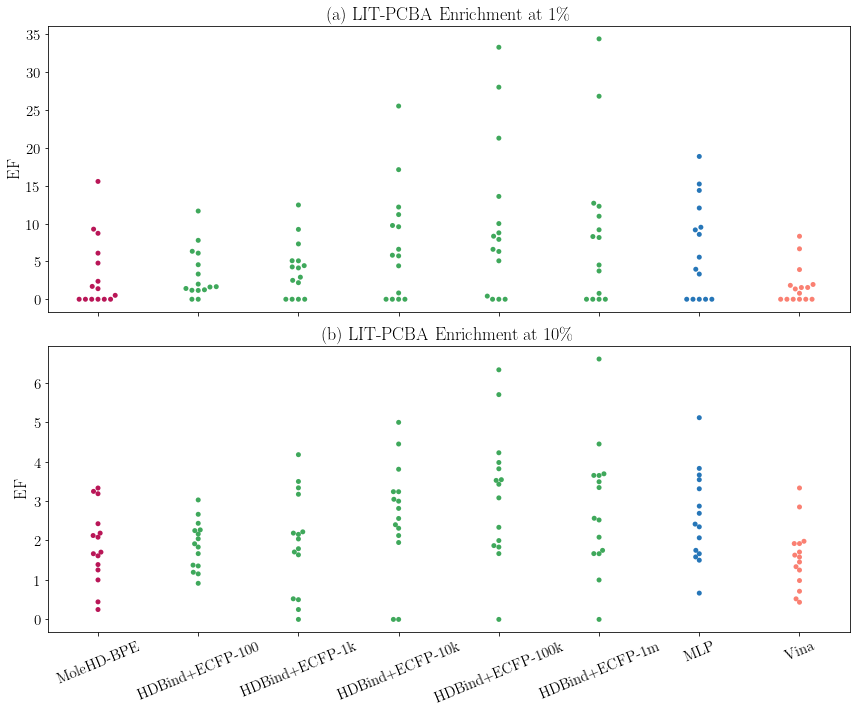

In [89]:
make_box_plot(enrich_1_df=grp_df[grp_df["p"] == .01], 
          enrich_10_df=grp_df[grp_df["p"] == .1],
             dataset="LIT-PCBA")

- should add the average EF (median?) to the labels on the horizontal axis
- scale the point size by standard deviation?
- standard scale the molformer embeddings?

In [26]:
def timing_plot(input_tup_list:list, dataset:str):
    
    
    f, ax = plt.subplots(1, 1, figsize=(12,10))
    
    df_dict = {"target": [], "model": [], "time": [], "format_name": []}
    for model_name, format_name in input_tup_list:
        
        data_path_list = list(data_p.glob(f"{model_name}.{dataset}*.pkl"))
        
        for path in data_path_list:
            with open(path, "rb") as handle:
                data = pickle.load(handle)
                
                test_time_list = []
                for i in range(10):
                    df_dict["time"].append(data["trials"][i]["test_time"]/data["y_test"].shape[0])
                    df_dict["target"].append(path.name)
                    df_dict["model"].append(model_name)
                    df_dict["format_name"].append(format_name)
                    

    df = pd.DataFrame(df_dict)
    xlabels = (df.groupby(["model", "format_name"]).median().reset_index()["format_name"]).values.tolist()
#     import pdb
#     pdb.set_trace()
    sns.swarmplot(data=df.groupby(["target", "model", "format_name"]).median().reset_index(),
                  order=[x for x in model_dict.keys()],
                  x="model", y="time", ax=ax)

    ax.tick_params(axis="x", labelrotation=22.5)
    ax.set_yscale("log")
#     labels = [item.get_text() for item in ax.get_xticklabels()]
#     labels = [x[1] for x in input_tup_list]
    ax.set_xticklabels(xlabels)
    
    f.savefig("lit-pcba-timing.png", dpi=600, bbox_inches="tight")
    
    return df
    

In [ ]:
time_df = timing_plot([("mlp-1024-1", "MLP (GPU)"),
            ("hdbind-rp-molformer", "RP-MolFormer (GPU)"),
            ("molehd-bpe", "MoleHD-BPE (CPU)"),
            ("hdbind-ecfp-1024-1-100", "RP-ECFP-100 (GPU)"),
                      ("hdbind-ecfp-1024-1-1k", "RP-ECFP-1k (GPU)"),
                      ("hdbind-ecfp-1024-1-100k", "RP-ECFP-100k (GPU)")], 
                      dataset="lit-pcba")

In [ ]:
avg_times = time_df.groupby(["model"]).mean()["time"].reset_index()
# avg_times.reset_index()

In [ ]:
avg_times["time"][0], avg_times["model"][0]

In [ ]:
avg_times["time"][1], avg_times["model"][1]

In [ ]:
avg_times["time"][2], avg_times["model"][2]

In [ ]:
avg_times["time"][3], avg_times["model"][3]

In [ ]:
avg_times["time"][4], avg_times["model"][4]

In [ ]:
avg_times["time"][5], avg_times["model"][5]

---

In [ ]:
100 * abs( avg_times["time"][0] - avg_times["time"][4])/(avg_times["time"][4])

In [ ]:
avg_times["time"][4] / avg_times["time"][0]

In [ ]:
avg_times["time"][5] / avg_times["time"][0]

In [ ]:
avg_times["time"][0] / avg_times["time"][1]

- theres way more parameters in the hdbind-rp-molformer as compared to the mlp
- (1024 * 10000 = 10.24M parameters)
- (
- can D go higher? a .85x slow down from 100 to 10000 seems pretty small, there also seems to be a considerable increase in accuracy when pushing D higher...